# Choose components PCA subreddits
In logistic regression, we extract the PCs of the subreddits features.
In this notebook we compare the AIC and BIC at the varying of the number of components.

In [2]:
import pandas as pd 
import numpy as np
import sys
sys.path += ["../src"]
from importlib import reload
import climact_utils as cu
import logistic_regression_activation as L
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from matplotlib.pyplot import subplots as sbp

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
subreddit_class = "activism"

In [4]:
print("Number of features for each class")
[f"{feat}: {len(cu.features[feat])}" for feat in cu.features if feat != "target"]

Number of features for each class


['control: 5',
 'interaction: 8',
 'norm_news: 3',
 'tot_news: 4',
 'subreddit: 1000',
 'sociodemo: 8']

In [5]:
lr_merge = L.LogisticRegression_activation("activism")
lr_sep = L.LogisticRegression_separate_pca("activism")
df = pd.read_csv(cu.data_path + f"authors_featurs_df/{subreddit_class}.csv.gz", compression = "gzip", index_col = [0,1])
# lr_merge.load_data()
# df = lr_merge.df
lr_sep.df = df
lr_merge.df = df

In [ ]:
# df.to_csv(cu.data_path + f"authors_featurs_df/{subreddit_class}.csv.gz", compression = "gzip")

In [9]:
k = 5
n_components_dict = {f"{feat}_{p}": len(cu.features[feat]) for feat in cu.features for p in cu.periods if feat not in ["target", "sociodemo", "tot_news"]}
n_components_dict.update({f"subreddit_{p}": k for p in ["short", "medium", "long", "short_long_ratio"]})
n_components_dict.update({"sociodemo": 8})

In [13]:
n_components_dict

{'control_short': 5,
 'control_medium': 5,
 'control_long': 5,
 'control_short_long_ratio': 5,
 'interaction_short': 8,
 'interaction_medium': 8,
 'interaction_long': 8,
 'interaction_short_long_ratio': 8,
 'norm_news_short': 3,
 'norm_news_medium': 3,
 'norm_news_long': 3,
 'norm_news_short_long_ratio': 3,
 'subreddit_short': 5,
 'subreddit_medium': 5,
 'subreddit_long': 5,
 'subreddit_short_long_ratio': 5,
 'sociodemo': 8}

In [14]:
exp_merge = lr_merge.repeated_bootstrap(n_samples = 10, n_components = sum(list(n_components_dict.values())), test = True)
exp_sep = lr_sep.repeated_bootstrap(n_samples = 10, n_components_dict = n_components_dict, test = True)

In [15]:
exp_merge[1]

,mean,std
accuracy,0.712175,0.011511
precision,0.750790,0.017589
recall,0.633989,0.015170
random_baseline,0.506767,0.005503


In [16]:
exp_sep[1]

,mean,std
accuracy,0.717423,0.010763
precision,0.735456,0.009543
recall,0.666157,0.021899
random_baseline,0.509967,0.007767


In [17]:
feature_to_class = {u: ft_class for ft_class in cu.features if ft_class not in ["target",  "tot_news", "sociodemo"]
                    for p in cu.periods  for u in cu.features_time[ft_class][p]}
feature_to_class.update({u: "sociodemo" for u in cu.features_join["sociodemo"]})

<Axes: xlabel='coef_sep', ylabel='coef_merge'>

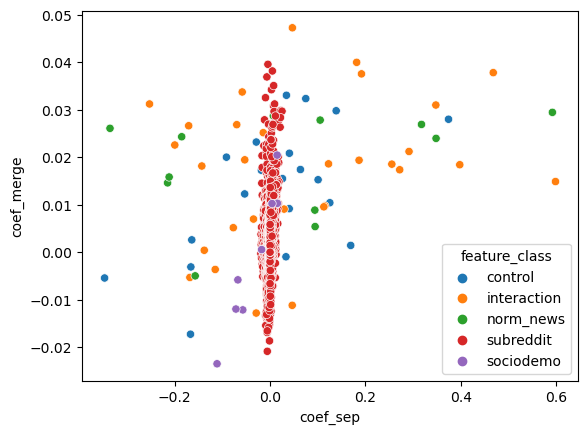

In [18]:
fig, axes = sbp()
sns.scatterplot(data = (pd.concat([exp_sep[0].rename(columns = {"coef": "coef_sep"})["coef_sep"], 
                exp_merge[0].rename(columns = {"coef": "coef_merge"})["coef_merge"]], axis = 1))
                .merge(pd.Series(feature_to_class, name = "feature_class"), left_index = True, right_index = True),
                x = "coef_sep", y = "coef_merge", hue = "feature_class"
                )

In [19]:
model_selection_list = []
for k in [1,2,4,8,16,32,64,128]:
    for _ in range(100):
        model_selection_list.append(L.model_selection(df, k = k, n_components_dict = None, separate_pca = True))

In [6]:
# model_selection_sep_pca = pd.DataFrame(model_selection_list).assign(k = lambda x: (x["k"] - 72) / 4)
# model_selection_sep_pca.to_csv(cu.data_path + f"experiments_logreg/model_selection_ncomponents_sep_pca_{subreddit_class}_240731.csv")
model_selection_sep_pca = pd.read_csv(cu.data_path + f"experiments_logreg/model_selection_ncomponents_sep_pca_{subreddit_class}_240731.csv", index_col = 0)

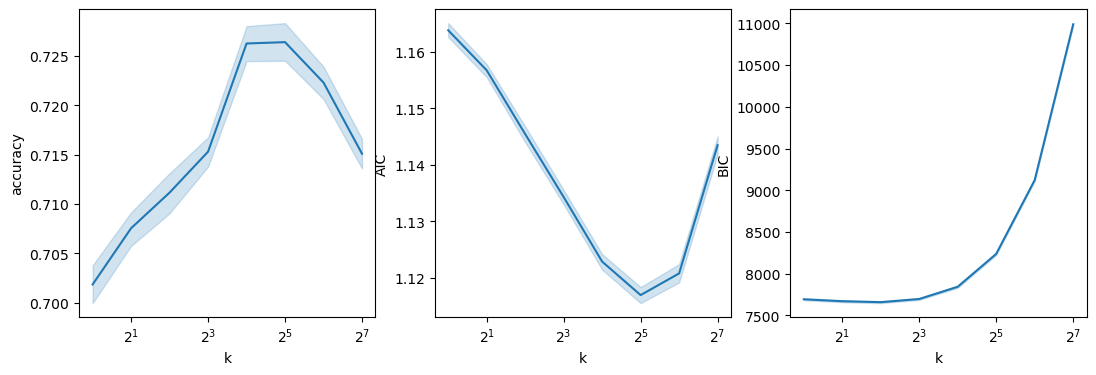

In [ ]:
fig, axes = sbp(ncols = 3, figsize = (13, 4))

for j,var in enumerate(["accuracy", "AIC", "BIC"]):
    sns.lineplot(data = model_selection_sep_pca, x = "k", y = var, ax = axes[j])
    axes[j].set_xscale("log", base = 2)

In [16]:
model_selection_list = []
for k in [1,2,4,8,16,32,64,128, 256]:
    print(k)
    for _ in range(100):
        model_selection_list.append(L.model_selection(df, k = k, n_components_dict = None, separate_pca = False))

256


In [5]:
# model_selection_merge_pca = pd.DataFrame(model_selection_list)
# model_selection_merge_pca.to_csv(cu.data_path + f"experiments_logreg/model_selection_ncomponents_merge_pca_{subreddit_class}_240731.csv")
model_selection_merge_pca = pd.read_csv(cu.data_path + f"experiments_logreg/model_selection_ncomponents_merge_pca_{subreddit_class}_240731.csv", index_col = 0)

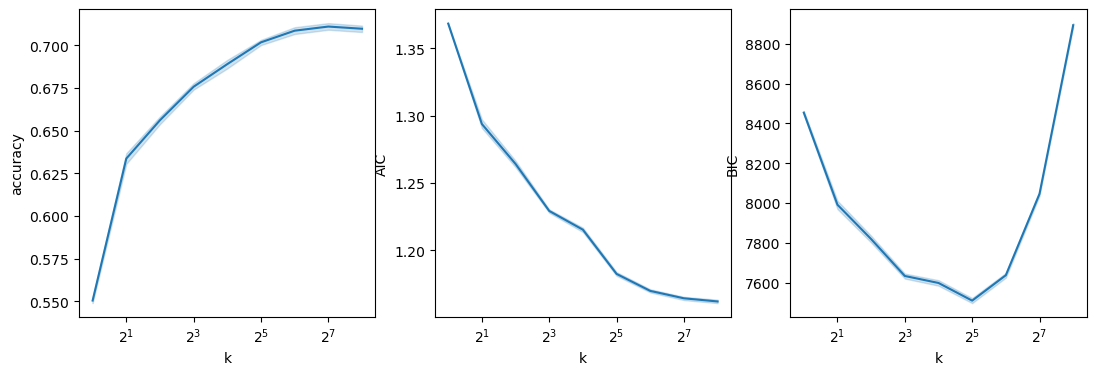

In [6]:
fig, axes = sbp(ncols = 3, figsize = (13, 4))

for j,var in enumerate(["accuracy", "AIC", "BIC"]):
    sns.lineplot(data = model_selection_merge_pca, x = "k", y = var, ax = axes[j])
    axes[j].set_xscale("log", base = 2)